In [2]:
import ipeadatapy as idpy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib notebook
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime

In [3]:
ipca = idpy.timeseries('PRECOS12_IPCAAB12')

In [4]:
ipca_serie = ipca[['VALUE ((% a.m.))']]

<AxesSubplot:>

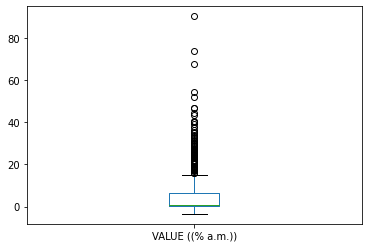

In [8]:
ipca_serie.plot(kind = 'box')

In [18]:
#substituir dados faltantes pela media
ipca_serie['VALUE ((% a.m.))'].fillna(ipca_serie['VALUE ((% a.m.))'].mean(), inplace=True)

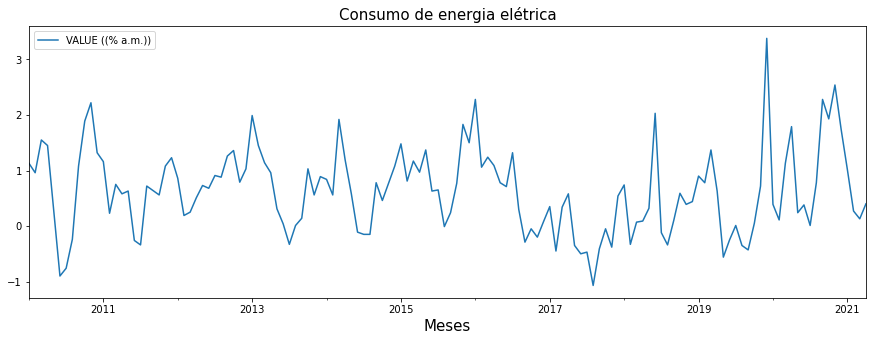

In [21]:
ipca_serie['2010':].plot(figsize = (15,5))
plt.xlabel('Meses',size=15)
plt.ylabel('')
plt.title('Consumo de energia elétrica',size=15)
plt.show()

In [22]:
# Cria-se um DF de 2010 para frente
ipca_serie = pd.DataFrame(ipca_serie['2010':])


<AxesSubplot:>

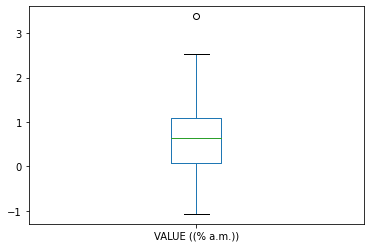

In [23]:
ipca_serie.plot(kind = 'box')

Decompor a serie

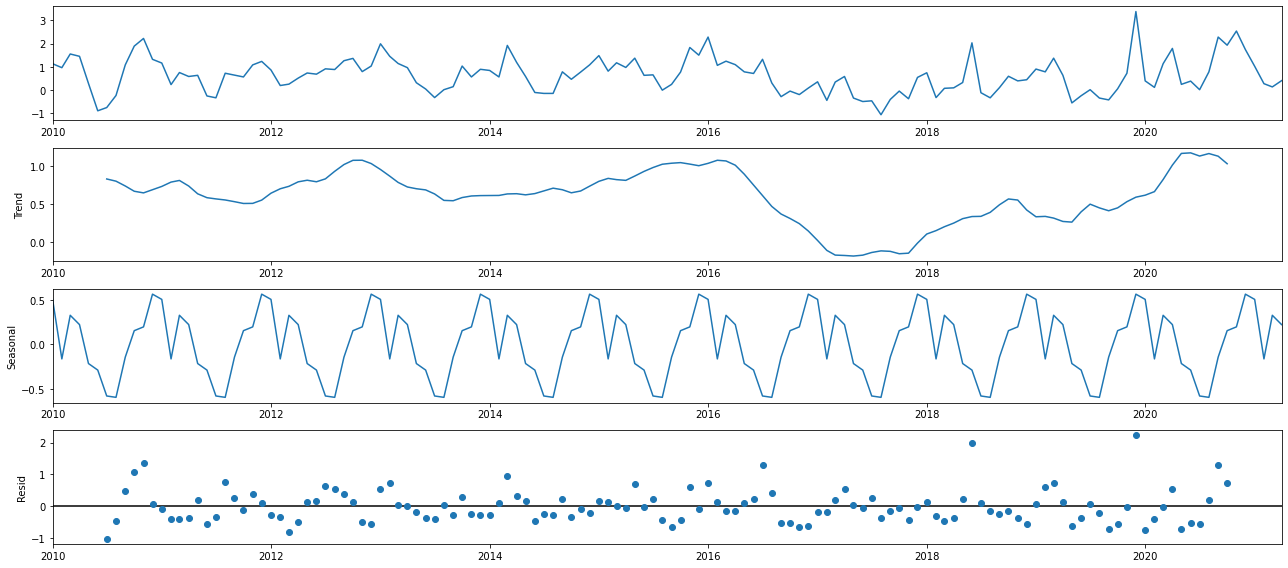

In [24]:
from pylab import rcParams

rcParams["figure.figsize"] = 18,8
decomposition = seasonal_decompose (ipca_serie, model = 'aditive')
fig = decomposition.plot()
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

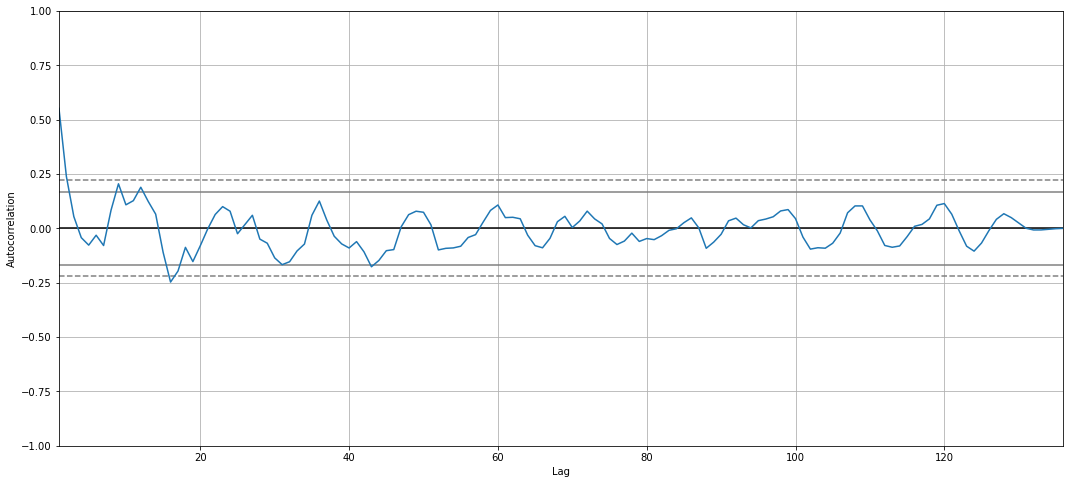

In [25]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(ipca_serie)

a serie a presenta-se estacionaria e nao precisa de diferenciação

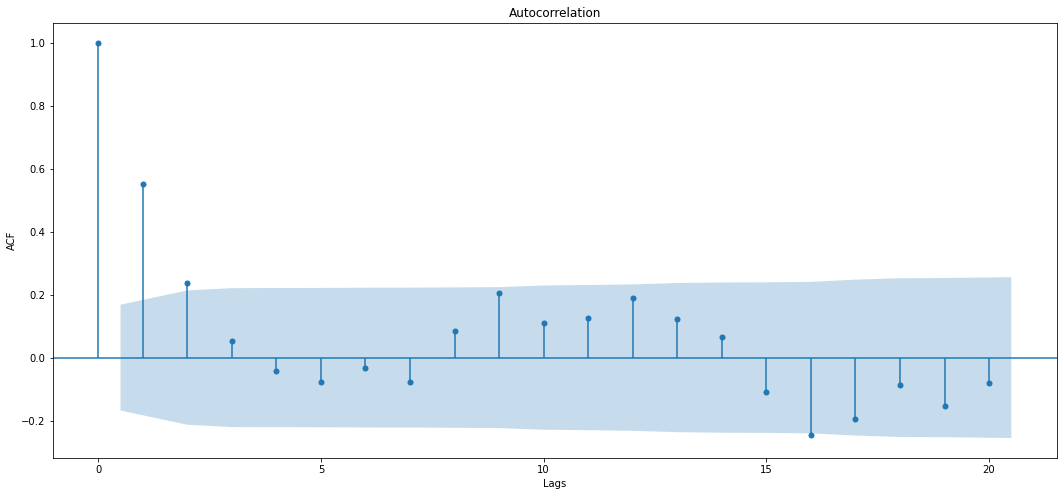

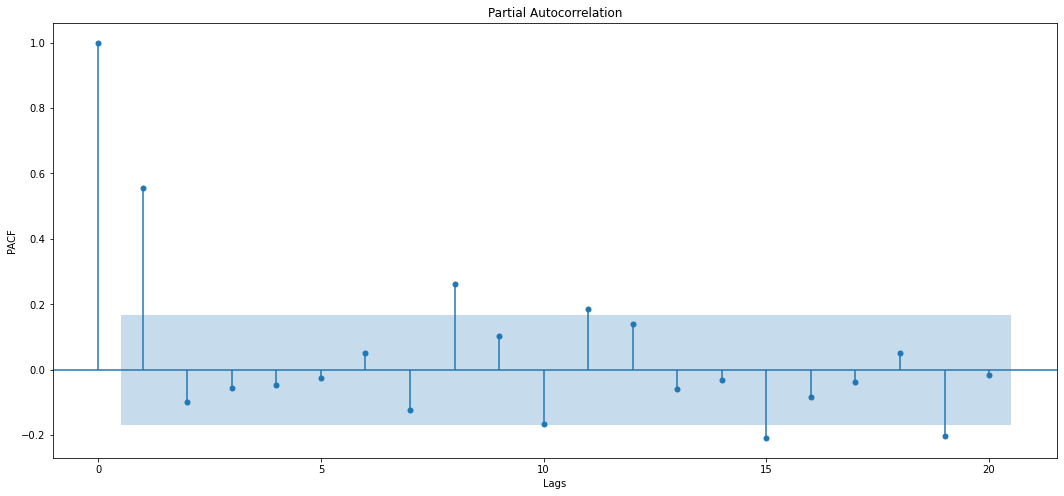

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot

#Analise de aucorrelação pelo ACF
plot_acf(ipca_serie, lags = 20)
plt.xlabel("Lags")
plt.ylabel("ACF")
pyplot.show()


plot_pacf(ipca_serie, lags = 20)
plt.xlabel("Lags")
plt.ylabel("PACF")
pyplot.show()


No grafico acima a autocorrelação é de terceira ordem, ou seja a observação esta correlacionda com as duas observações anteriores. Visto que os lags 1 e 2 passao da linha azul (intervalo de confiança) 

Teste de ADF

In [27]:
#Função de ADF
def adf(resultado):
  result = adfuller(resultado)
  print("ADF statistic: %f"% result[0])
  print("\np-value: %f"%result[1]) # se p for menor que 0.05 os dados sao estacionarios
  if result[1]<0.05:
      print("Estacionaria\n")
  else:
    print("Não Estacionaria\n")

  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [56]:
#Teste ADF
adf(ipca_serie)

ADF statistic: -6.202164

p-value: 0.000000
Estacionaria

Critical Values:
	1%: -3.480
	5%: -2.883
	10%: -2.578


Modelo para criação dos parametros ARIMA

In [28]:
# Gerando combinação de parametros
import itertools # Biblioteca de geração de combinações

p =d =q = range(0,2)
pdq = list(itertools.product(p,d,q)) # criação das combinações p,d,q
seasonal_pdq = [(x[0],x[1],x[2],12) for x in pdq] # criação das combinações P,D,Q


#Saida
print("Exemplos de parametros de combinação sazonal ARIMA")
print("SARIMAX:{} x {}".format(pdq[1],seasonal_pdq[1]))
print("SARIMAX: {} x {}".format(pdq[1], seasonal_pdq[2]))
print("SARIMAX: {} x {}".format(pdq[2], seasonal_pdq[3]))
print("SARIMAX: {} x {}".format(pdq[2], seasonal_pdq[4]))

Exemplos de parametros de combinação sazonal ARIMA
SARIMAX:(0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Usando o SARIMA

In [29]:
#Busca-se o melhor parametro para SARIMA. Deve-se escolher o menor AIC
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

aic = []
bic =[]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ipca_serie,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            aic.append(results.aic)
            bic.append(results.bic)

            print('ARIMA{}x{}12 - AIC: {} - BIC:{}'.format(param, param_seasonal, results.aic, results.bic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC: 380.32249017311824 - BIC:383.22776495155665
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC: 318.5137190541477 - BIC:324.13808776489253
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC: 330.0271207812221 - BIC:332.83930513659453
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC: 261.6740520075585 - BIC:267.09311241018315
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC: 301.36833325819913 - BIC:307.0088963894092
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC: 284.2439952304154 - BIC:292.68054829653266
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC: 283.8368703783683 - BIC:289.27386812095847
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC: 261.77402393187384 - BIC:269.90261453581087
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC: 314.3191685522489 - BIC:320.1148481521507
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC: 271.83222552906324 - BIC:280.244288663263
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC: 299.90081948056246 - BIC:305.50886157002896
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC: 234.0052908476538 - BIC:242.10673194503107
ARIMA(0, 0, 1)x(1, 0, 0, 12

In [30]:
#Analise do modelo com os parametros selecionados
mod = sm.tsa.statespace.SARIMAX(ipca_serie, oder=(1,0,0), seasonal_order = (0,1,1,12),enforce_invertibility=False,)
results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                     VALUE ((% a.m.))   No. Observations:                  136
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -123.043
Date:                              Mon, 31 May 2021   AIC                            252.086
Time:                                      15:40:41   BIC                            260.547
Sample:                                  01-01-2010   HQIC                           255.523
                                       - 04-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5351      0.058      9.301      0.000       0.422       0.648
ma.S.L12      -0.83

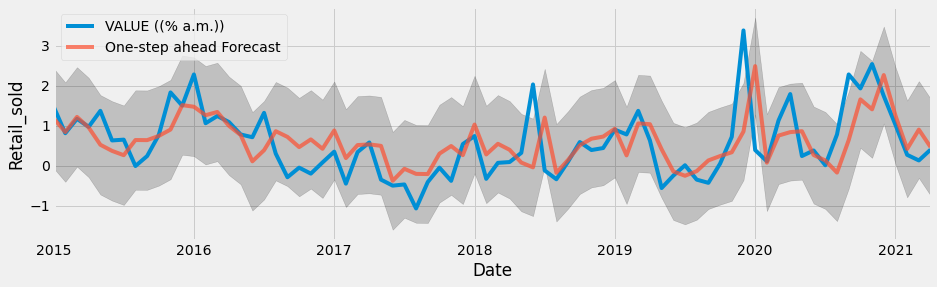

In [35]:
pred = results.get_prediction(start=pd.to_datetime('2015'), dynamic=False) #indica o inicio da previsao
pred_ci = pred.conf_int() #valores max e min da previsao
ax = ipca_serie['2015':].plot(label='observed') # periodo real dos dados a comparar com a previsao

#plotando o grafico
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

In [36]:
#impressao do datframe predito max e min
pred_ci

,lower VALUE ((% a.m.)),upper VALUE ((% a.m.))
2015-01-01,-0.061069,2.434644
2015-02-01,-0.403719,2.080824
2015-03-01,-0.023825,2.460718
2015-04-01,-0.288726,2.195817
2015-05-01,-0.720515,1.764028
...,...,...
2020-12-01,1.053558,3.475732
2021-01-01,0.040887,2.461415
2021-02-01,-0.792340,1.627268
2021-03-01,-0.308393,2.111215


In [37]:
#media das predições
pred.predicted_mean

2015-01-01    1.186788
2015-02-01    0.838552
2015-03-01    1.218447
2015-04-01    0.953546
2015-05-01    0.521757
                ...   
2020-12-01    2.264645
2021-01-01    1.251151
2021-02-01    0.417464
2021-03-01    0.901411
2021-04-01    0.465079
Freq: MS, Name: predicted_mean, Length: 76, dtype: float64

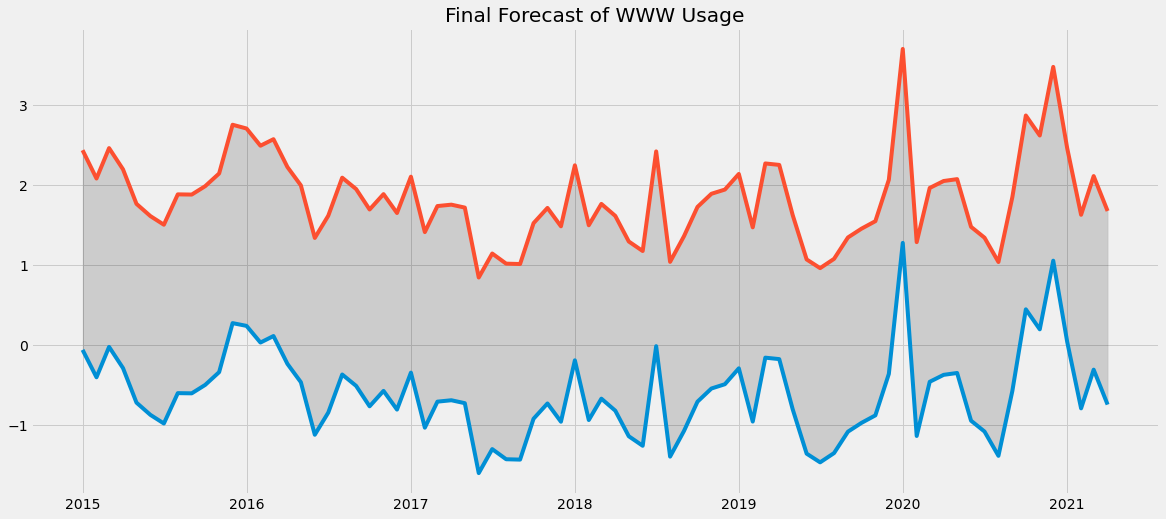

In [38]:
# Grafico de margem da venda
plt.plot(pred_ci)
plt.fill_between(pred_ci.index, 
                 pred_ci['lower VALUE ((% a.m.))'], 
                 pred_ci['upper VALUE ((% a.m.))'], 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

## Ate este ponto o modelo foi realizado e os dados preditos. Agora é preciso analisar quanto o modelo atende a veracidade dos dados

1º. Analise de residuos por meio do grafico de resiudos e comportamento de normalidade e correlação

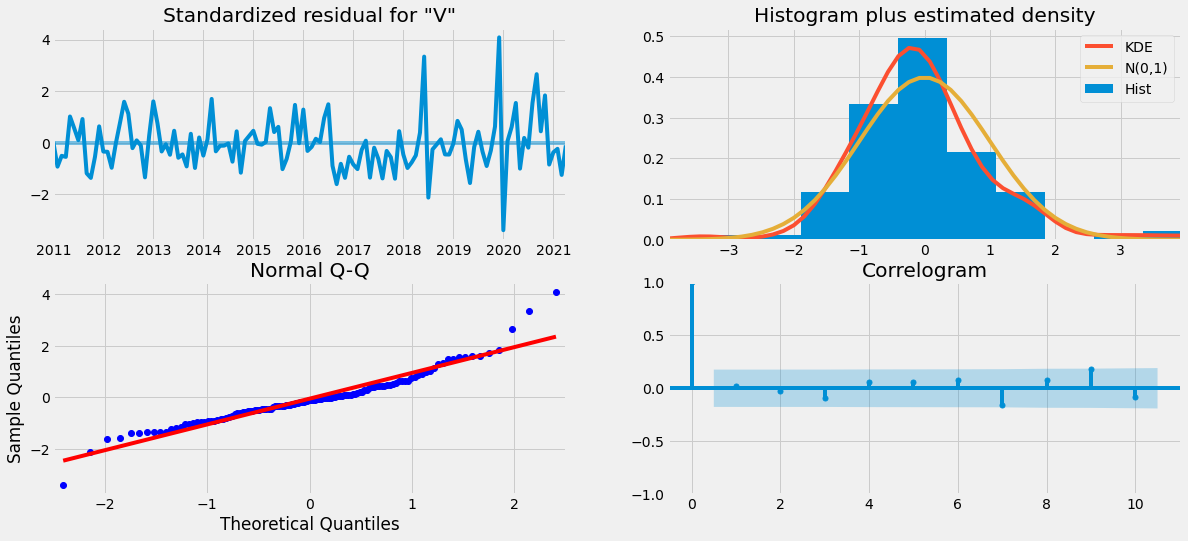

In [39]:
#Analise dos resultados
results.plot_diagnostics(figsize=(18, 8))
plt.show()

obs Sobre o grafico acima:
    # Grafico de normalidade: linha KDE esta proxima do N(0,1,), onde 0 é a media e 1 desvio padrão
    # Grafico q-q: indica que os valores residuais estao proximo a linha N(0,1), ou seja normais

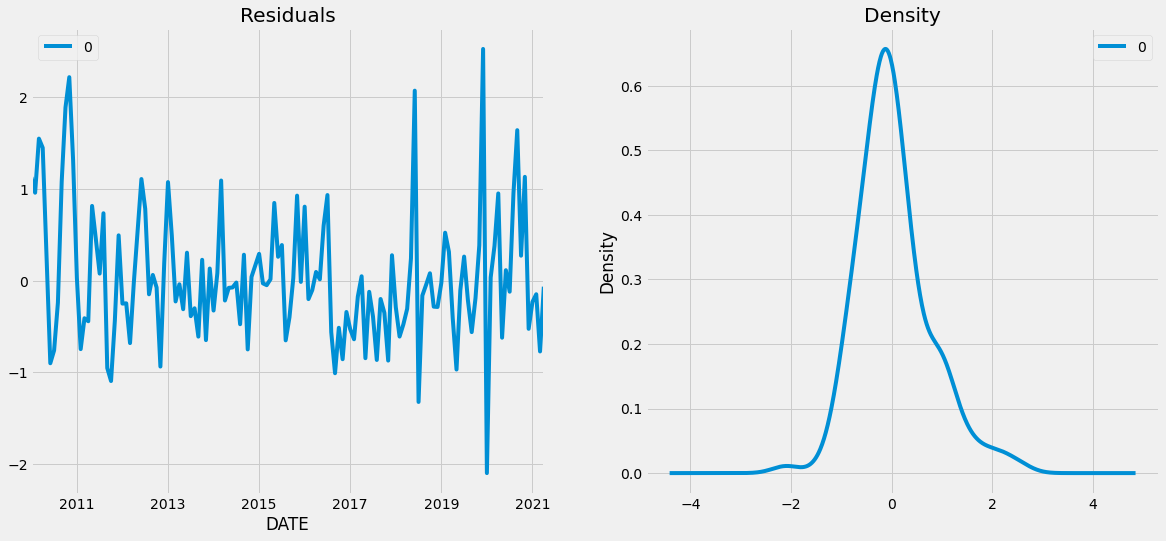

In [40]:
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [41]:
residuals.describe()

,0
count,136.000000
mean,0.038239
std,0.722894
min,-2.098223
25%,-0.400175
50%,-0.056763
75%,0.307963
max,2.527941


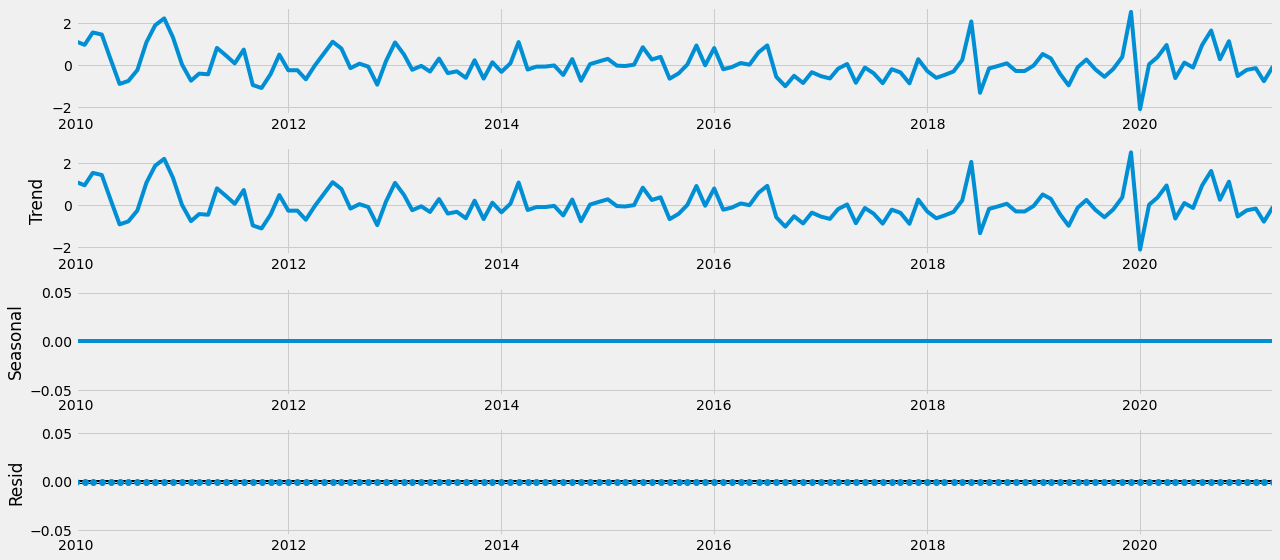

In [70]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(residuals, model = 'additive', freq = 1)
result.plot()
pyplot.show()

2º. CALCULANDO O MAE, MSE E RMSE PARA AVALIAR A DIFERENÇA DA MEDIA PREDITA

In [43]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mae = mean_absolute_error(ipca_serie['2015':], pred.predicted_mean)
mse = mean_squared_error(ipca_serie['2015':], pred.predicted_mean)
rmse = math.sqrt(mse)

print('VALOR MAE: {}, VALOR DO MSE: {}, VALOR DO RMSE:{}'.format(round(mae,2), round(mse,2),round(rmse,2)))



VALOR MAE: 0.5, VALOR DO MSE: 0.49, VALOR DO RMSE:0.7


REALIZANDO PREVISAO COM ETAPAS A FRENTE

In [44]:
# Realização da previsao escolhendo quantos steps a frente. Steps depende do tempo usado - mes, ano etc.
predicao = results.get_forecast(steps =8)

In [45]:
#valores preditos
predicao.conf_int()

,lower VALUE ((% a.m.)),upper VALUE ((% a.m.))
2021-05-01,-1.197859,1.221749
2021-06-01,-1.209317,1.534883
2021-07-01,-1.422098,1.408184
2021-08-01,-1.448115,1.406331
2021-09-01,-0.941726,1.919588
2021-10-01,-0.686427,2.176811
2021-11-01,-0.465750,2.397896
2021-12-01,-0.098013,2.765254


In [46]:
#valores medios paara previsao
predicao.predicted_mean

2021-05-01    0.011945
2021-06-01    0.162783
2021-07-01   -0.006957
2021-08-01   -0.020892
2021-09-01    0.488931
2021-10-01    0.745192
2021-11-01    0.966073
2021-12-01    1.333620
Freq: MS, Name: predicted_mean, dtype: float64

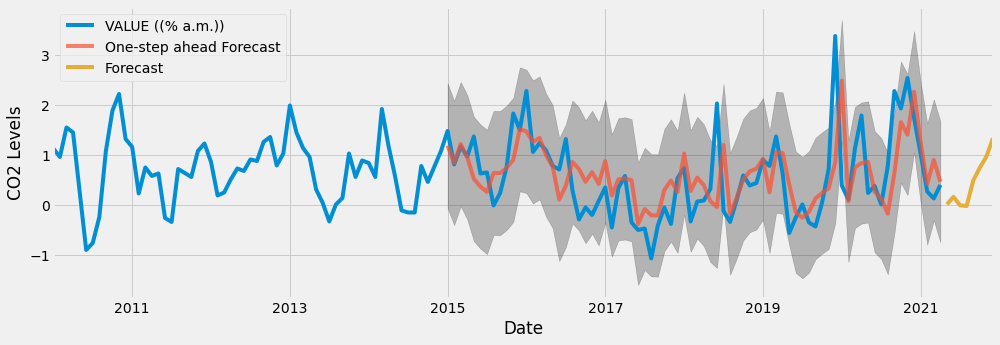

In [47]:
# GRAFICO DE PROJEÇÃO
ax = ipca_serie.plot(label='observed', figsize=(15, 5)) # valores reais
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7) # valores preditos
predicao.predicted_mean.plot(ax=ax, label='Forecast') # valores a frente(steps)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

PREVISAO IPCA ACUMULADO PARA O ANO 2021

In [48]:
print('PREVISAO IPCA 2021:', predicao.predicted_mean.sum() + ipca_serie['2021-01':].sum())

PREVISAO IPCA 2021: VALUE ((% a.m.))    5.500695
dtype: float64
